In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the datasets
preprocessed_fraudTrain = pd.read_csv('preprocessed_fraudTrain.csv')
preprocessed_fraudTest = pd.read_csv('preprocessed_fraudTest.csv')

# Encode categorical features using Label Encoding or OneHot Encoding
label_enc = LabelEncoder()
for col in ['merchant', 'category', 'gender', 'city', 'state', 'job']:
    preprocessed_fraudTrain[col] = label_enc.fit_transform(preprocessed_fraudTrain[col])
    preprocessed_fraudTest[col] = label_enc.transform(preprocessed_fraudTest[col])

# Separate features and target
X_train = preprocessed_fraudTrain.drop(columns=['is_fraud'])
y_train = preprocessed_fraudTrain['is_fraud']
X_test = preprocessed_fraudTest.drop(columns=['is_fraud'])
y_test = preprocessed_fraudTest['is_fraud']

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [2]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training dataset
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build the autoencoder
autoencoder = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),  # Bottleneck layer
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(X_train_resampled.shape[1], activation='sigmoid')
])

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_resampled, X_train_resampled, epochs=50, batch_size=256, validation_split=0.2)


/Users/rajthakur/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/50


/Users/rajthakur/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8058/8058 ━━━━━━━━━━━━━━━━━━━━ 4s 476us/step - loss: 0.9492 - val_loss: 1.1334
Epoch 2/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 4s 470us/step - loss: 0.8204 - val_loss: 1.1309
Epoch 3/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 4s 463us/step - loss: 0.8165 - val_loss: 1.1296
Epoch 4/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 4s 468us/step - loss: 0.8156 - val_loss: 1.1290
Epoch 5/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 4s 465us/step - loss: 0.8140 - val_loss: 1.1170
Epoch 6/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 4s 464us/step - loss: 0.8113 - val_loss: 1.1169
Epoch 7/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 4s 468us/step - loss: 0.8096 - val_loss: 1.1163
Epoch 8/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 4s 463us/step - loss: 0.8072 - val_loss: 1.1164
Epoch 9/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 4s 472us/step - loss: 0.8077 - val_loss: 1.1162
Epoch 10/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 4s 463us/step - loss: 0.8125 - val_loss: 1.1158
Epoch 11/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 4s 469us/step - loss: 0.8117 - val_loss: 1.1156
Epoch 12/50
8058/80

In [4]:
autoencoder = Sequential()
autoencoder.add(Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)))
autoencoder.add(Dropout(0.2))  # Add dropout for regularization
autoencoder.add(Dense(32, activation='relu'))
autoencoder.add(Dropout(0.2))
autoencoder.add(Dense(16, activation='relu'))
autoencoder.add(Dense(32, activation='relu'))
autoencoder.add(Dense(64, activation='relu'))
autoencoder.add(Dense(X_train_resampled.shape[1], activation='sigmoid'))

autoencoder.compile(optimizer='adam', loss='mean_squared_error')


NameError: name 'Dropout' is not defined

In [5]:
# Extract compressed (bottleneck) features from the autoencoder
encoder = Sequential(autoencoder.layers[:3])  # Use the first 3 layers (encoder)
X_train_encoded = encoder.predict(X_train_resampled)
X_test_encoded = encoder.predict(X_test_scaled)

# Build the ANN classifier
classifier = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile and train the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train_encoded, y_train_resampled, epochs=10, batch_size=256, validation_data=(X_test_encoded, y_test))

80574/80574 ━━━━━━━━━━━━━━━━━━━━ 18s 217us/step
17367/17367 ━━━━━━━━━━━━━━━━━━━━ 4s 221us/step
Epoch 1/10
10072/10072 ━━━━━━━━━━━━━━━━━━━━ 4s 392us/step - accuracy: 0.8697 - loss: 0.3042 - val_accuracy: 0.9147 - val_loss: 0.2133
Epoch 2/10
10072/10072 ━━━━━━━━━━━━━━━━━━━━ 4s 367us/step - accuracy: 0.9077 - loss: 0.2207 - val_accuracy: 0.8912 - val_loss: 0.2585
Epoch 3/10
10072/10072 ━━━━━━━━━━━━━━━━━━━━ 4s 384us/step - accuracy: 0.9142 - loss: 0.2060 - val_accuracy: 0.8904 - val_loss: 0.2577
Epoch 4/10
10072/10072 ━━━━━━━━━━━━━━━━━━━━ 4s 381us/step - accuracy: 0.9183 - loss: 0.1978 - val_accuracy: 0.9218 - val_loss: 0.1920
Epoch 5/10
10072/10072 ━━━━━━━━━━━━━━━━━━━━ 4s 387us/step - accuracy: 0.9195 - loss: 0.1949 - val_accuracy: 0.9066 - val_loss: 0.2215
Epoch 6/10
10072/10072 ━━━━━━━━━━━━━━━━━━━━ 4s 379us/step - accuracy: 0.9209 - loss: 0.1919 - val_accuracy: 0.9081 - val_loss: 0.2188
Epoch 7/10
10072/10072 ━━━━━━━━━━━━━━━━━━━━ 4s 368us/step - accuracy: 0.9215 - loss: 0.1906 - val_acc

In [6]:
# Evaluate the model
loss, accuracy = classifier.evaluate(X_test_encoded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


17367/17367 ━━━━━━━━━━━━━━━━━━━━ 4s 223us/step - accuracy: 0.9250 - loss: 0.1864
Test Accuracy: 0.9152


17367/17367 ━━━━━━━━━━━━━━━━━━━━ 4s 231us/step


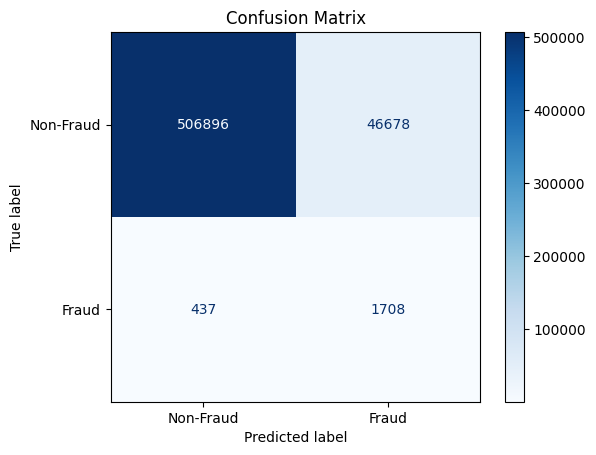

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = classifier.predict(X_test_encoded)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [8]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = classifier.predict(X_test_encoded)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud'])

# Print the report
print(report)


17367/17367 ━━━━━━━━━━━━━━━━━━━━ 4s 236us/step
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.92      0.96    553574
       Fraud       0.04      0.80      0.07      2145

    accuracy                           0.92    555719
   macro avg       0.52      0.86      0.51    555719
weighted avg       1.00      0.92      0.95    555719

